# Rendering from multiple view points

## Overview

In this tutorial, you will learn how to render a given scene from multiple points of view. This can be very convenient if you wish to generate a large synthetic dataset, or are doing some multi-view optimization.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Load Mitsuba objects</li>
  <li>Create sensors</li>
  <li>Render a scene from a specified sensor</li>
</ul>

</div>

## Setup

Let us start by importing `mitsuba` and setting the variant.

In [2]:
import mitsuba as mi
mi.set_variant("scalar_rgb")

## Loading a scene


In [previous tutorials][6], we have seen how to load a Mitsuba scene from an XML file. In Mitsuba 3, it is also possbile to load a scene defined by Python dictionary using [<code>load_dict()</code>][1].

In fact, the `load_dict()` function allows us to load any Mitsuba object by describing it as a Python `dict`. The exact form of the dictionary can be easily deduced from the equivalent XML representation, and more information on this subject can be found in the dedicated [documentation chapter][2]. The [plugin documentation][3] also shows how to load each plugin using either XML or `dict`. Everything achievable with the XML scene format should be achievable using Python `dict`s as well.

In the following cell, we instantiate a scene containing a teapot mesh and a constant light source. This tutorial makes heavy use of the [<code>ScalarTransform4f</code>][4] class to create transformations. Take a look at the dedicated [How-to Guide][5] for more information on how to use it.

<div class="admonition important alert alert-block alert-info">

🗒 **Note**

Notice the `Scalar` prefix in `ScalarTransform4f`. This indicates that no matter which variant of Mitsuba is enabled, this type will always refer to the CPU scalar transformation type (which can also be accessed with `mitsuba.scalar_rgb.Transform4f`. The same applies to all basic types (e.g. `Float`, `UInt32`) and other data-structure type (e.g. `Ray3f`, `SurfaceInteraction3f`), which can all be prefixed with `Scalar` to obtain the corresponding CPU scalar type.

</div>

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict
[2]: https://mitsuba.readthedocs.io/en/latest/src/key_topics/scene_format.html#scene-python-dict-format
[3]: https://mitsuba.readthedocs.io/en/latest/src/plugin_reference.html
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ScalarTransform4f
[5]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/transformation_toolbox.html#Transform
[6]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html#Loading-a-scene

In [3]:
# Create an alias for convenience
from mitsuba import ScalarTransform4f as T

scene = mi.load_dict({
    'type': 'scene',
    # The keys below correspond to object IDs and can be chosen arbitrarily
    'integrator': {'type': 'path'},
    'light': {'type': 'constant'},
    'teapot': {
        'type': 'ply',
        'filename': '../scenes/meshes/teapot.ply',
        'to_world': T.translate([0, 0, -1.5]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {'type': 'rgb', 'value': [0.1, 0.2, 0.3]},
        },
    },
})

Next, let's create our sensors!

## Creating sensors

Mitsuba provides a high level `Sensor` abstraction, along with a `Film` abstraction, which define how radiance from our scene should be recorded. For the purpose of this tutorial, we will focus on the sensor's placement and skip over all other parameters. Of course, if you wished to do so, it is entirely possible to define multiple radically different sensors. You can learn more about the different types of sensors and films that are included in Mitsuba in the [plugin documentation][1]. 

In this tutorial, we are going to render our scene from multiple points of view placed around the teapot in a circular fashion. To this end, let's define a helper function `load_sensor` that creates a sensor with a specific position given as input in spherical coordinates. As previously mentionned, `load_dict()` can be used to load a single Mitsuba object too and not just entire scenes, so let's make use of it here.

Note that although we create a new `sampler` and `film` per sensor instance, it is possible to create a single instance of each that are then shared by all sensors.

[1]: https://mitsuba.readthedocs.io/en/latest/src/plugin_reference.html

In [4]:
def load_sensor(r, phi, theta):
    # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
    origin = T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])

    return mi.load_dict({
        'type': 'perspective',
        'fov': 39.3077,
        'to_world': T.look_at(
            origin=origin, 
            target=[0, 0, 0], 
            up=[0, 0, 1]
        ),
        'sampler': {
            'type': 'independent', 
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 256,
            'height': 256,
            'rfilter': {
                'type': 'tent',
            },
            'pixel_format': 'rgb',
        },
    })

## Rendering using a specific sensor

The [<code>render()</code>][1] function can take quite a few aditional arguments. In a previous tutorial, we have seen that we can specify the number of samples per pixel with the keyword argument `spp`. We can also dynamically specify a sensor with the `sensor` keyword argument that should be used instead of the first sensor defined in the scene, which would be used by default. The previous [tutorial][2] showed how `mi.traverse` can be used to edit scenes. That same mechanism could be used to edit the sensor after each render. However, we would be limited to editing the parameters that are exposed by the object. The `sensor` keyword argument of `render` is therefore much more powerful if you wish to render a same scene from mulitple points of view.

In this example, we place the sensors at a fixed latitude (defined by `theta`) on a large sphere of radius `radius` centered on the teapot, and vary the longitude with different values of $\phi$ (defined by `phis`).

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.render
[2]: https://mitsuba.readthedocs.io/en/latest/src/rendering/editing_a_scene.html

In [5]:
sensor_count = 6

radius = 12
phis = [20.0 * i for i in range(sensor_count)]
theta = 60.0

sensors = [load_sensor(radius, phi, theta) for phi in phis]

We are now ready to render from each of our sensors.

In [6]:
images = [mi.render(scene, spp=16, sensor=sensor) for sensor in sensors]

Finally, we can use the convenient [<code>Bitmap</code>][1] class to quickly visualize our six rendered images directly in the notebook.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap

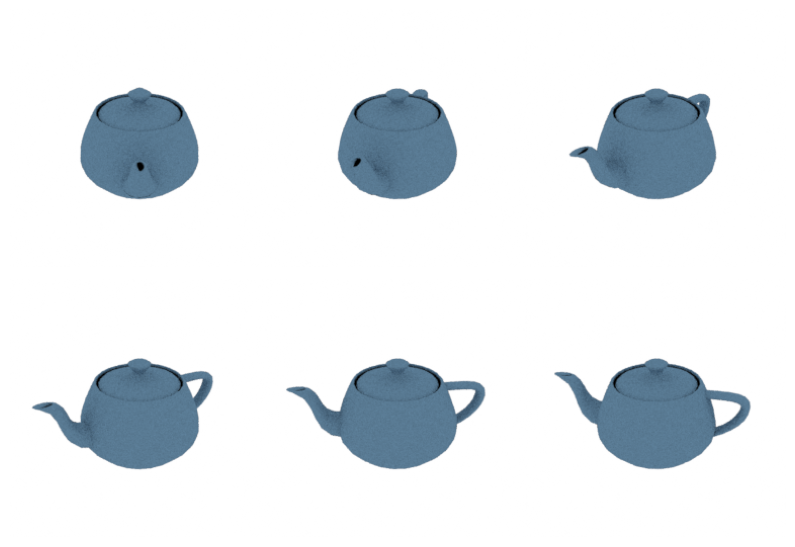

In [7]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(sensor_count):
    ax = fig.add_subplot(2, 3, i + 1).imshow(images[i] ** (1.0 / 2.2))
    plt.axis("off")

## See also

- [<code>mitsuba.load_dict()</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict)
- [Mitsuba dictionary format](https://mitsuba.readthedocs.io/en/latest/src/key_topics/scene_format.html#scene-python-dict-format)